In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
    LabelEncoder,
)
from sklearn.svm import SVC
from xgboost import XGBClassifier

sns.set_theme(style="white", palette="viridis")
plt.style.use("fivethirtyeight")
pd.set_option("display.max_columns", None)

In [2]:
train_filename = "train.csv"
test_filename = "test.csv"
original_filename = "horse.csv"

real_train_df = pd.read_csv(train_filename, index_col="id", na_values=["None"])
real_test_df = pd.read_csv(test_filename, index_col="id", na_values=["None"])
real_original_df = pd.read_csv(original_filename, na_values=["None"])

In [3]:
def get_basic_information(df):
    desc = pd.DataFrame(index=list(df.columns))
    desc["count"] = df.count()
    desc["nunique"] = df.nunique()
    desc["null"] = df.isnull().sum()
    desc["type"] = df.dtypes
    desc = pd.concat([desc, df.describe().T], axis=1)
    return desc

In [4]:
real_train_df.head(5)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [5]:
get_basic_information(real_train_df)

,count,nunique,null,type,count,mean,std,min,25%,50%,75%,max
surgery,1235,2,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,1235,2,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospital_number,1235,255,0,int64,1235.0,954500.401619,1.356403e+06,521399.0,528800.0,529777.0,534145.0,5305129.0
rectal_temp,1235,43,0,float64,1235.0,38.202186,7.886678e-01,35.4,37.8,38.2,38.6,40.8
pulse,1235,50,0,float64,1235.0,79.574089,2.910864e+01,30.0,53.0,76.0,100.0,184.0
respiratory_rate,1235,37,0,float64,1235.0,30.054251,1.645207e+01,8.0,18.0,28.0,36.0,96.0
temp_of_extremities,1196,4,39,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peripheral_pulse,1175,4,60,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mucous_membrane,1214,6,21,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capillary_refill_time,1229,3,6,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
real_test_df.head(5)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1235,no,adult,534053,38.6,40.0,20.0,normal,normal,normal_pink,less_3_sec,mild_pain,hypomotile,slight,none,none,7.0,normal,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
1236,yes,adult,528469,38.2,112.0,48.0,cool,reduced,bright_pink,more_3_sec,depressed,hypomotile,moderate,slight,none,3.5,decreased,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
1237,yes,adult,528178,37.7,66.0,12.0,cool,normal,bright_red,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.0,normal,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
1238,no,adult,534784,37.1,88.0,20.0,cool,reduced,pale_cyanotic,less_3_sec,depressed,absent,severe,slight,more_1_liter,2.0,absent,distend_large,75.0,81.0,NaN,1.0,yes,1400,0,0,no
1239,yes,adult,529840,38.3,50.0,12.0,NaN,normal,bright_pink,less_3_sec,mild_pain,absent,slight,slight,none,3.0,decreased,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes


In [7]:
get_basic_information(real_test_df)

,count,nunique,null,type,count,mean,std,min,25%,50%,75%,max
surgery,824,2,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,824,2,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospital_number,824,210,0,int64,824.0,1.108357e+06,1.555627e+06,521399.0,528743.0,529808.5,534644.0,5305129.0
rectal_temp,824,34,0,float64,824.0,3.824454e+01,7.852339e-01,36.0,37.8,38.2,38.6,40.8
pulse,824,49,0,float64,824.0,8.022937e+01,2.916471e+01,36.0,54.0,76.0,100.0,184.0
respiratory_rate,824,38,0,float64,824.0,3.071966e+01,1.743191e+01,9.0,18.0,28.0,36.0,96.0
temp_of_extremities,789,4,35,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peripheral_pulse,777,4,47,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mucous_membrane,811,6,13,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capillary_refill_time,818,3,6,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# test_df has only one unique value for lesion_3 (0), so we can drop it
real_train_df.drop("lesion_3", axis=1, inplace=True)
real_test_df.drop("lesion_3", axis=1, inplace=True)

In [9]:
def compute_roc_auc(train_df, test_df):
    train = train_df.copy()
    test = test_df.copy()
    train.drop("outcome", axis=1, inplace=True)

    train["is_train"] = 1
    test["is_train"] = 0

    data = pd.concat([train, test], ignore_index=True)
    shuffled_data = data.sample(frac=1.0)
    x = shuffled_data.drop("is_train", axis=1)
    y = shuffled_data["is_train"]

    skf = StratifiedKFold(n_splits=4, random_state=0, shuffle=True)
    validation_scores = []
    predictions = np.zeros(len(data))

    for train_idx, val_idx in skf.split(x, y):
        pipeline = make_pipeline(
            ColumnTransformer(
                [
                    (
                        "cat_cols",
                        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
                        categorical_features,
                    ),
                    ("num_cols", StandardScaler(), numerical_features),
                ]
            ),
            RandomForestClassifier(max_depth=6, min_samples_leaf=6),
        )
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        pipeline.fit(x_train, y_train)
        probs = pipeline.predict_proba(x_val)[:, 1]
        predictions[val_idx] = probs
        val_score = roc_auc_score(y_val, probs)
        validation_scores.append(val_score)

    fpr, tpr, _ = roc_curve(shuffled_data["is_train"], predictions)

    plt.figure(figsize=(10, 10))
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
    sns.lineplot(x=fpr, y=tpr, label="Classifier")
    plt.title(f"Validation = {np.mean(validation_scores):.5f}", weight="bold", size=16)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()


def compute_outliers(df):
    fig, axes = plt.subplots(
        nrows=(len(numerical_features) + 2) // 3, ncols=3, figsize=(10, 10)
    )

    for col, ax in zip(numerical_features, axes.ravel()):
        if "outcome" in df.columns:
            sns.boxplot(data=df, x="outcome", y=col, ax=ax)
        else:
            sns.boxplot(data=df, x=col, ax=ax)
        ax.set_xlabel("")
        ax.set_title(f"{col}", fontsize=12)

    fig.suptitle("Outliers", y=0.98)
    fig.tight_layout()
    plt.show()


def compute_numerical_feature_distribution(train_df, test_df):
    fig, axes = plt.subplots((len(numerical_features) + 1) // 2, 2, figsize=(16, 20))
    axes = axes.flatten()

    for i, feature in enumerate(numerical_features):
        ax = axes[i]
        sns.kdeplot(train_df[feature], ax=ax, color="red", alpha=0.5)
        sns.kdeplot(test_df[feature], ax=ax, color="blue", alpha=0.5)
        ax.set_title(f"{feature} KDE Plot", size=16)
        ax.grid(False)
        ax.set_xlabel(None)

    fig.suptitle("Distribution of Numerical Features", fontsize=20)
    fig.legend(["Train", "Test"])
    plt.tight_layout()
    plt.show()

In [10]:
train_df = real_train_df.copy()
test_df = real_test_df.copy()

In [11]:
numerical_features = list(real_test_df.select_dtypes(include="number").columns)
categorical_features = list(real_test_df.select_dtypes(exclude="number").columns)
print(numerical_features)
print(categorical_features)

['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2']
['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']


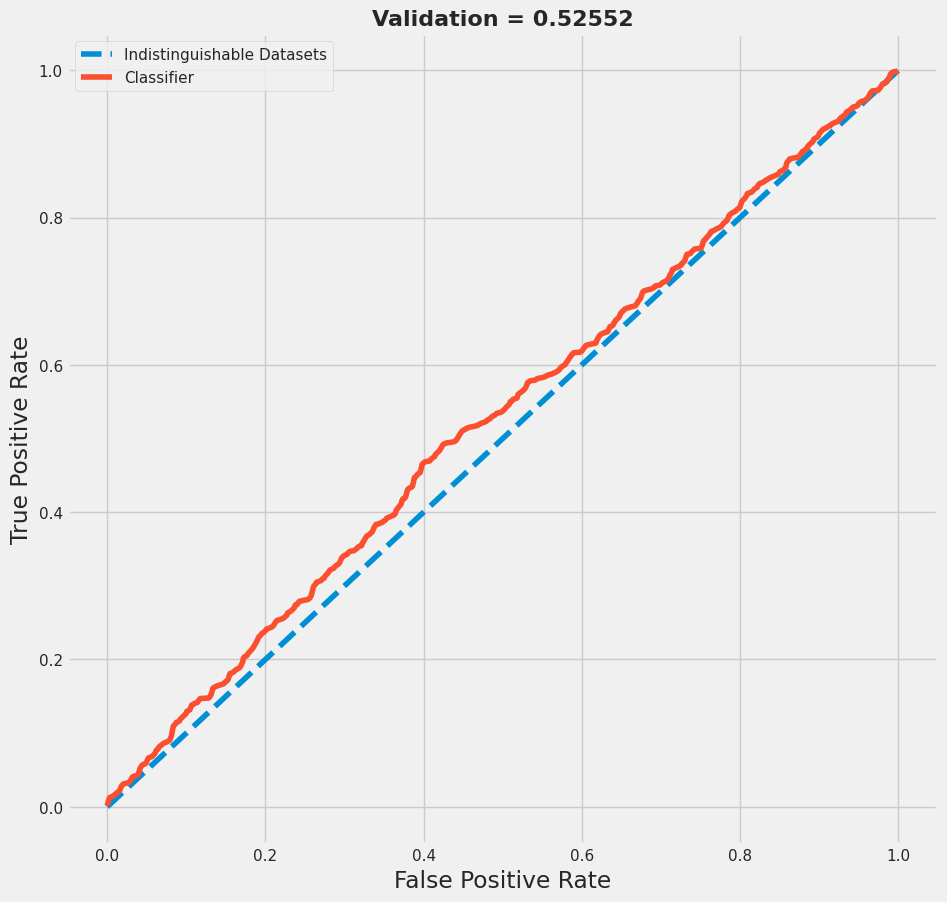

In [12]:
compute_roc_auc(train_df, test_df)

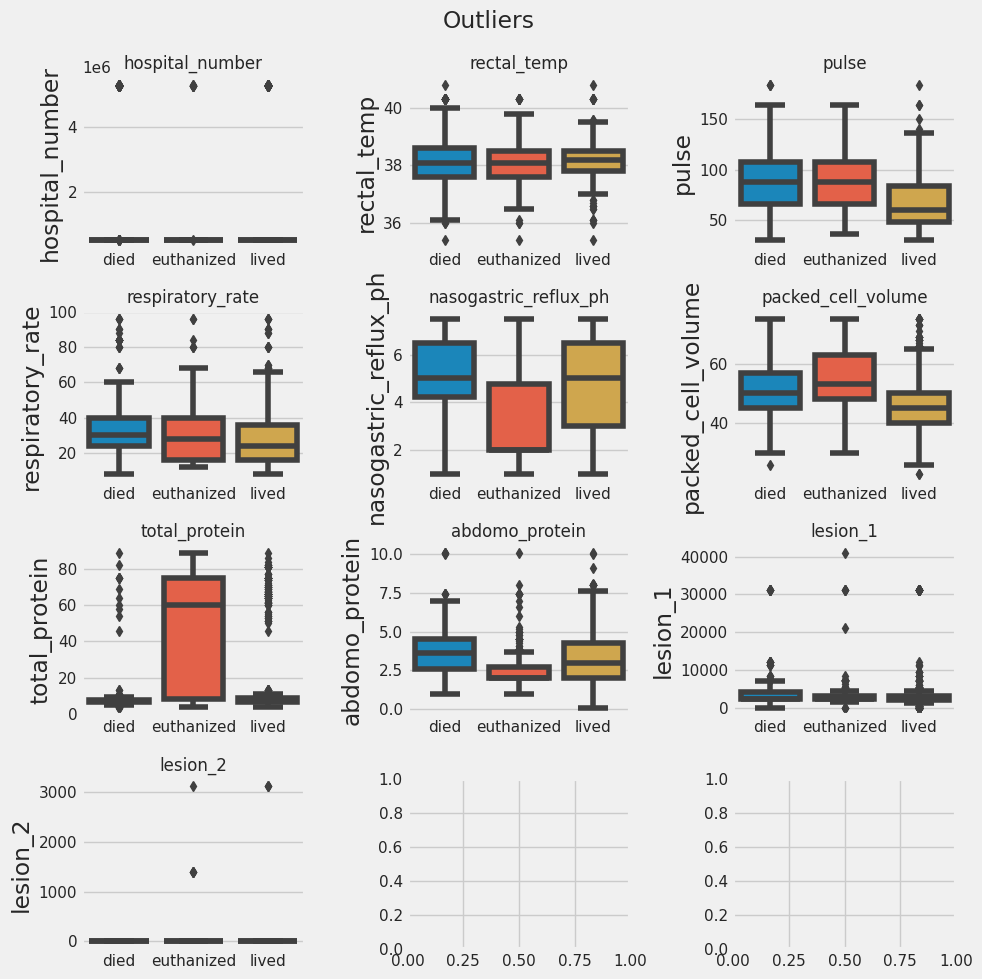

In [13]:
compute_outliers(train_df)

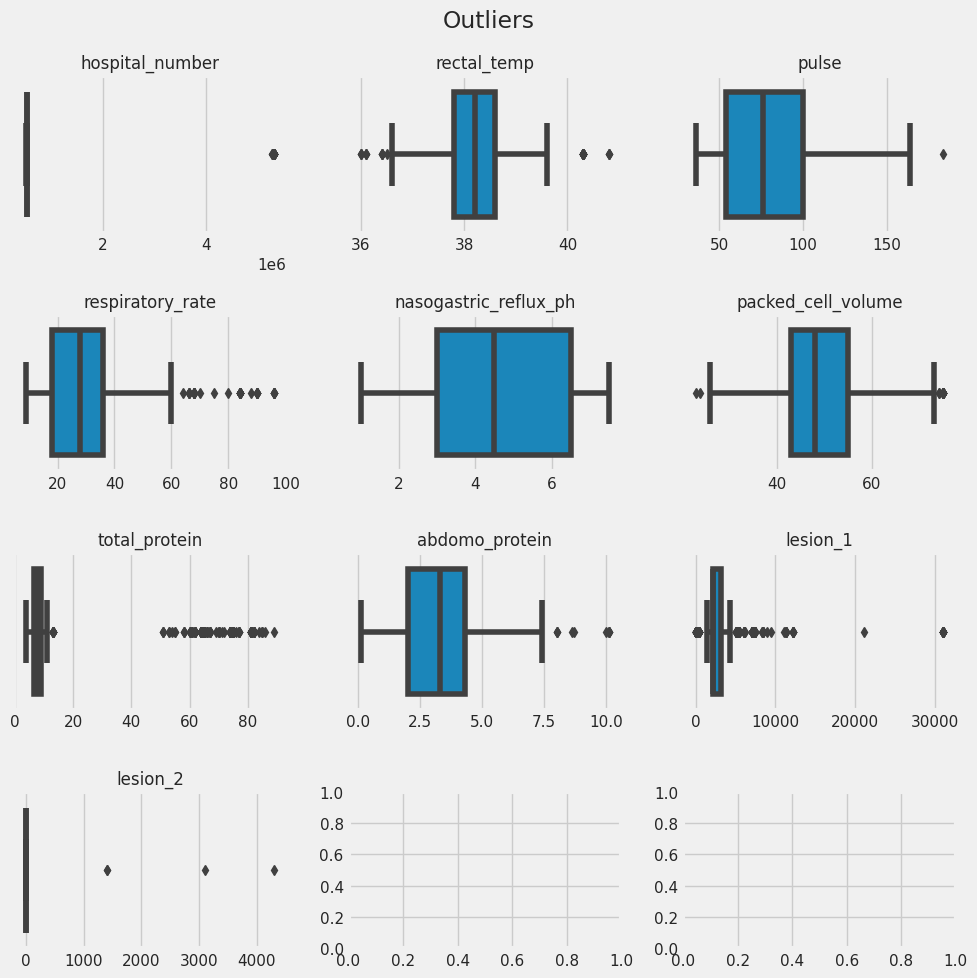

In [14]:
compute_outliers(test_df)

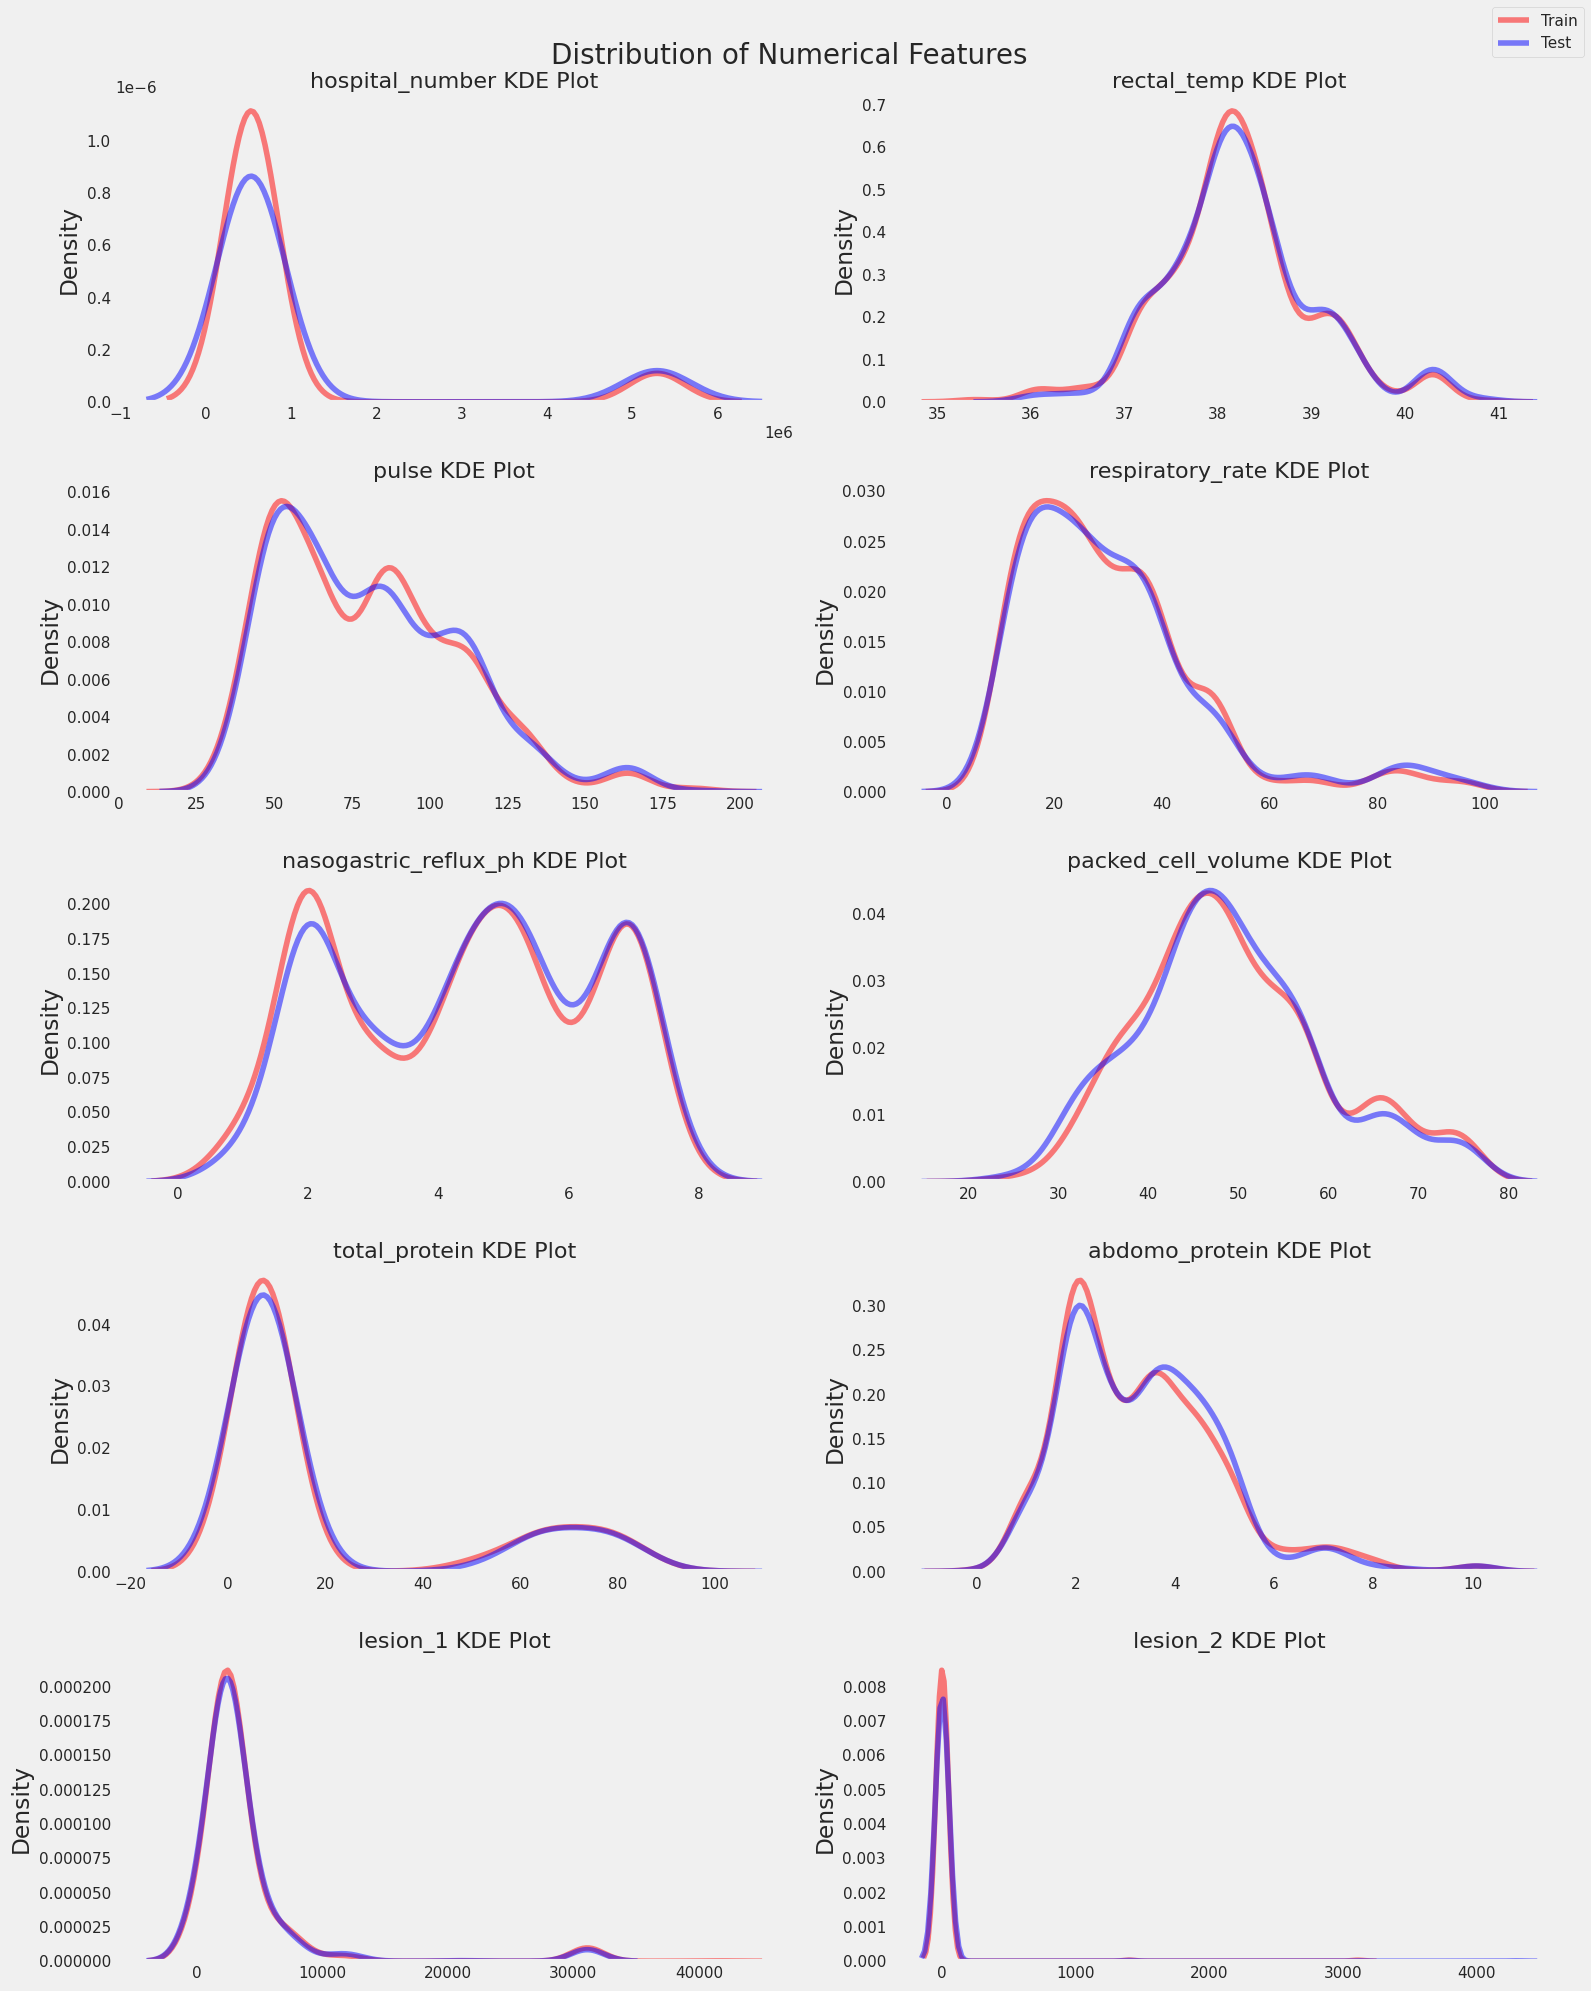

In [15]:
compute_numerical_feature_distribution(train_df, test_df)

/home/arrow/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x800 with 0 Axes>

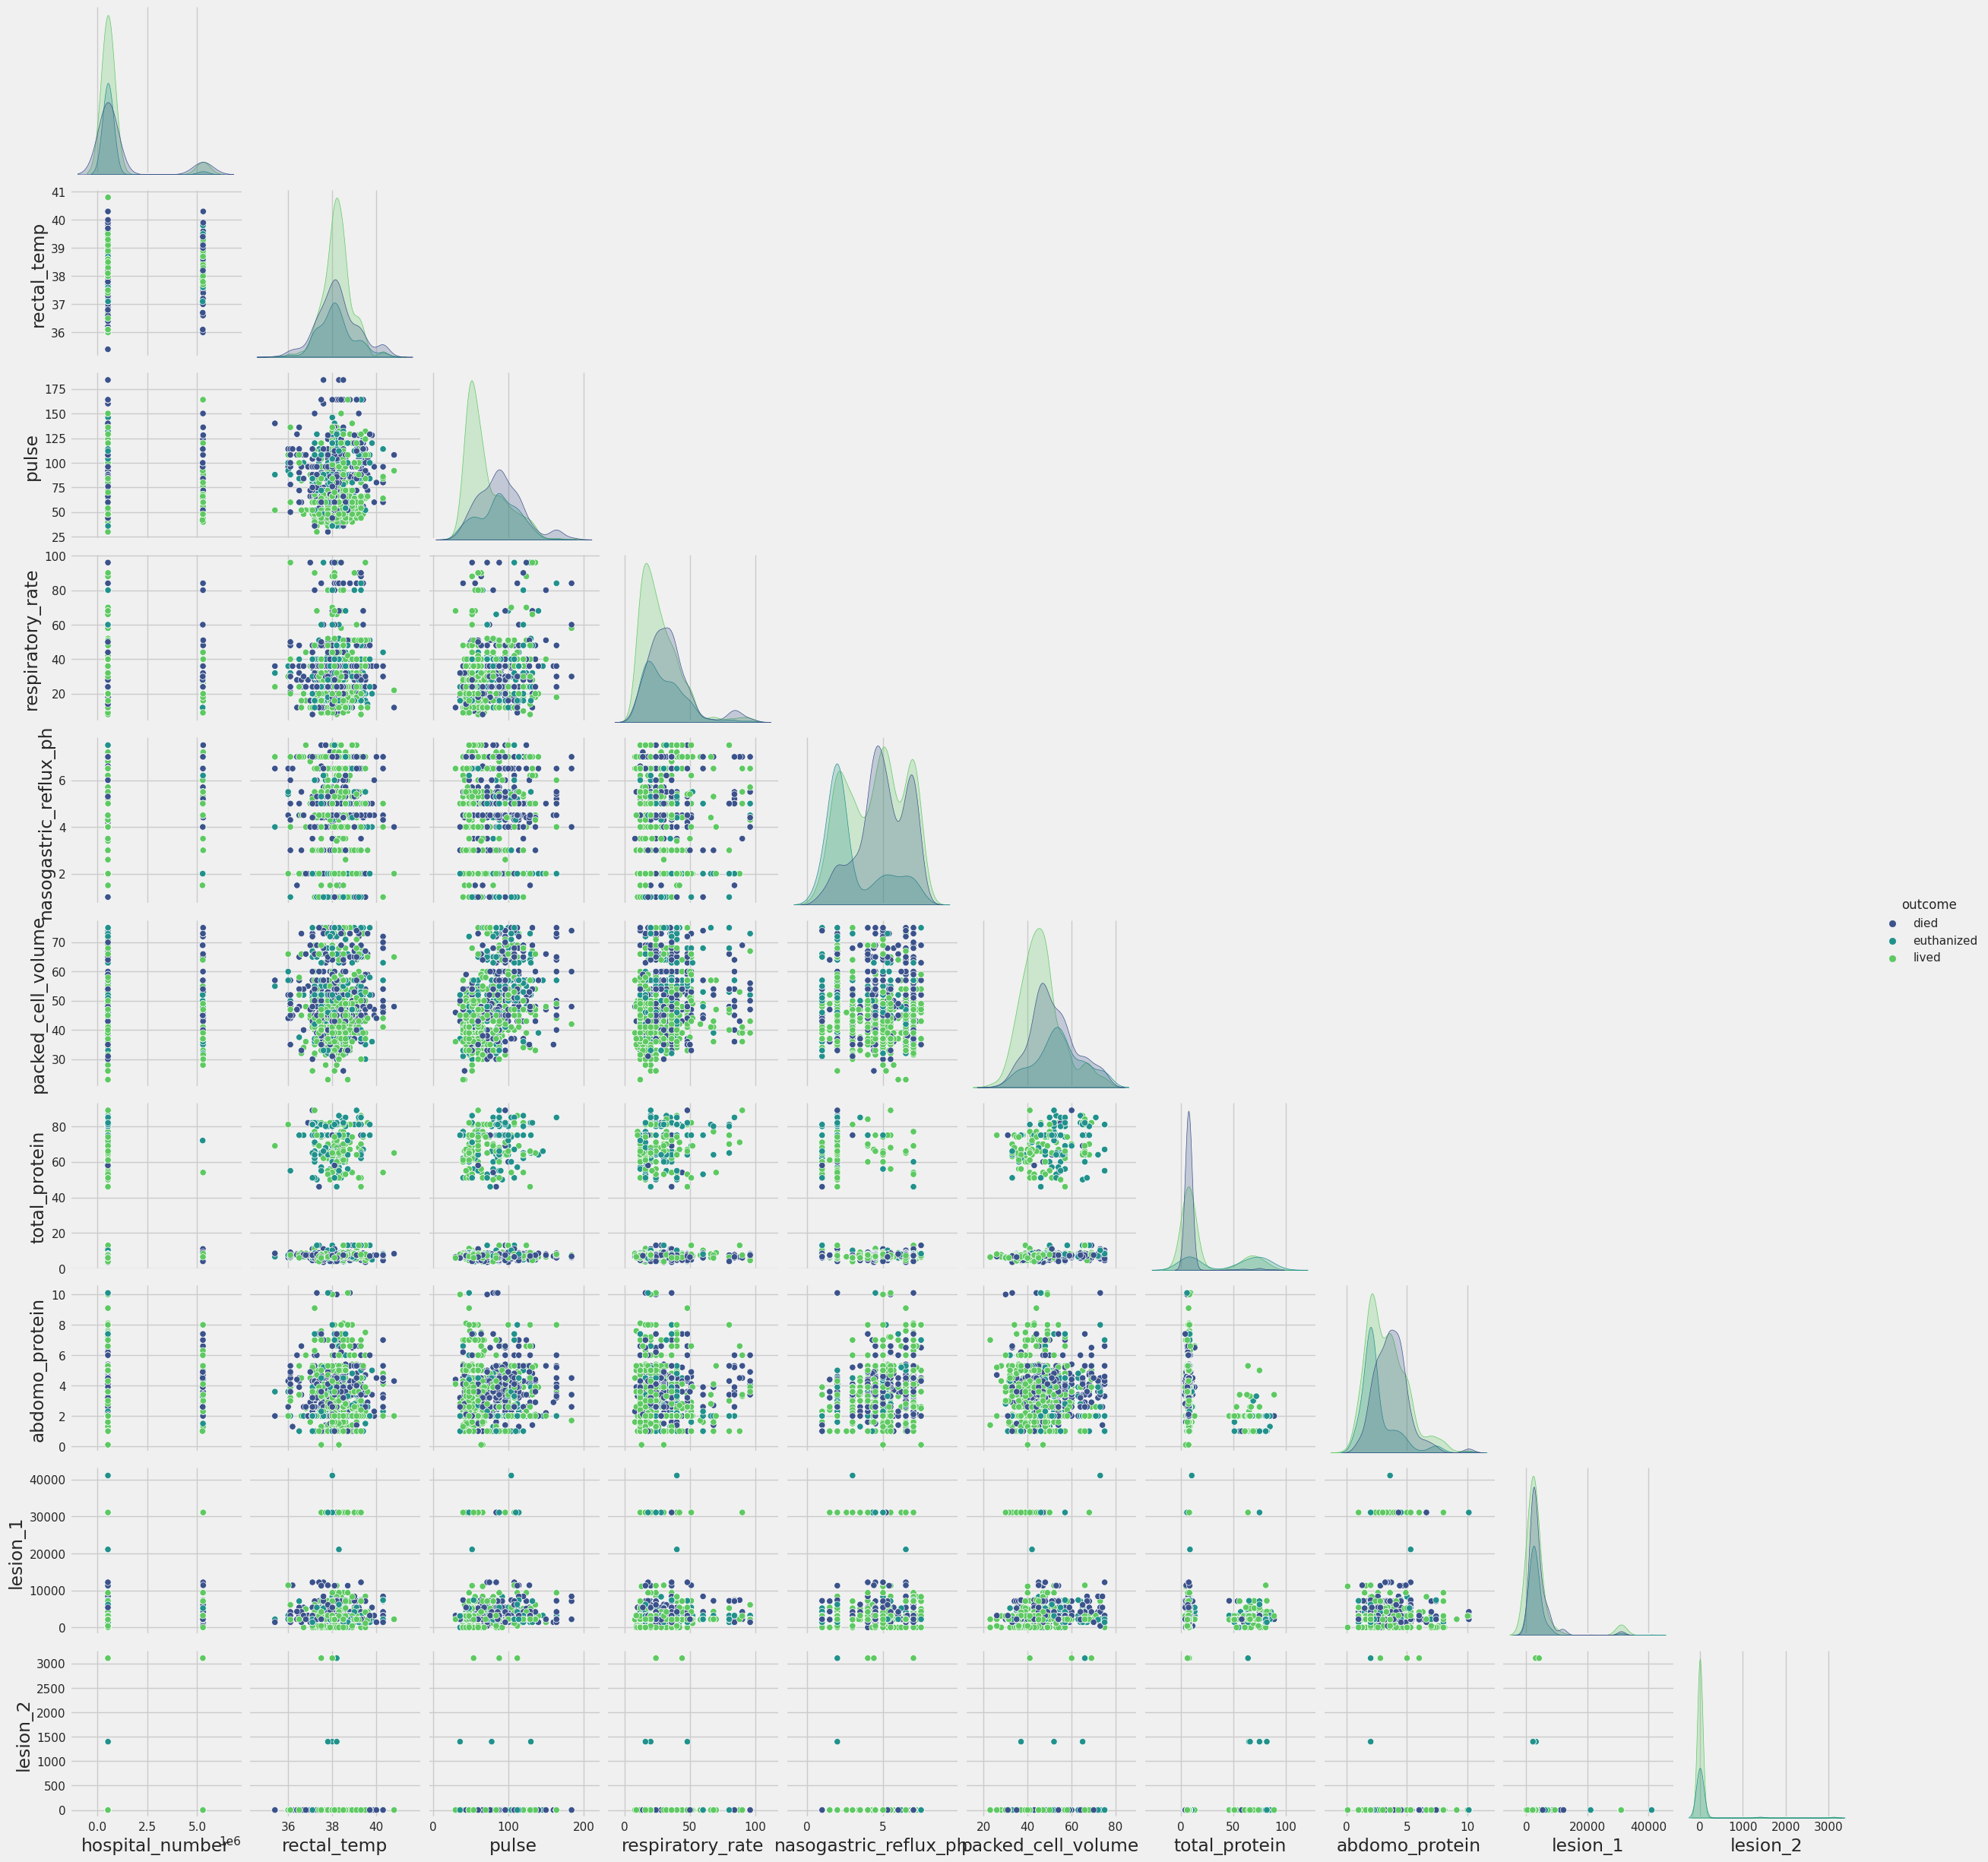

In [16]:
plt.figure(figsize=(10, 8))
sns.pairplot(
    data=train_df[numerical_features + ["outcome"]],
    hue="outcome",
    corner=True,
    palette="viridis",
)
plt.grid(None)
plt.show()

In [112]:
lesion_first_number = {
    "1": "gastric",
    "2": "sm_intestine",
    "3": "lg_colon",
    "4": "lg_colon_and_cecum",
    "5": "cecum",
    "6": "transverse_colon",
    "7": "retum/descending_colon",
    "8": "uterus",
    "9": "bladder",
    "11": "all_intestinal_sites",
    "00": "none",
}
lesion_second_number = {
    "1": "simple",
    "2": "strangulation",
    "3": "inflammation",
    "4": "other",
    "0": "none",
}
lesion_third_number = {
    "1": "mechanical",
    "2": "paralytic",
    "0": "none",
}
lesion_fourth_number = {
    "1": "obturation",
    "2": "intrinsic",
    "3": "extrinsic",
    "4": "adynamic",
    "5": "volvulus/torsion",
    "6": "intussuption",
    "7": "thromboembolic",
    "8": "hernia",
    "9": "lipoma/slenic_incarceration",
    "10": "displacement",
    "0": "none",
}


def IQR(col):
    q1 = np.percentile(col, 25)
    q3 = np.percentile(col, 75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    lower_outliers = col < lower_bound
    upper_outliers = col > upper_bound

    col = np.where(lower_outliers, round(lower_bound, 3), col)
    col = np.where(upper_outliers, round(upper_bound, 3), col)
    return col


def lesion_split(s: str):
    if s[:2] in ["00", "11"]:
        first, second, third, fourth = s[:2], s[2], s[3], s[4]
    elif s[0] == "0":
        first, second, third, fourth = s[1], s[2], s[3], s[4]
    else:
        first, second, third, fourth = s[0], s[1], s[2], s[3:]

    return [
        lesion_first_number.get(first, "none"),
        lesion_second_number.get(second, "none"),
        lesion_third_number.get(third, "none"),
        lesion_fourth_number.get(fourth, "none"),
    ]


def preprocess_lesion(df, lesion: str):
    lesion_columns = [
        f"{lesion}_site",
        f"{lesion}_type",
        f"{lesion}_subtype",
        f"{lesion}_specific_code",
    ]
    split_lesion = split_lesion = (
        df[lesion].astype(str).str.zfill(5).apply(lesion_split)
    )
    lesion_df = pd.DataFrame(split_lesion.tolist(), columns=lesion_columns)
    df = pd.concat([df, lesion_df.set_index(df.index)], axis=1)
    df.drop(lesion, inplace=True, axis=1)
    return df


def preprocess_hospital_number(df):
    col = "hospital_number"
    # df[col] = df[col].astype(str)
    return df


def preprocess_protein(df):
    new_col = "protein_category"
    col = "total_protein"
    df.loc[df[col] > 40, new_col] = "high"
    df.loc[df[col] < 40, new_col] = "low"
    df.drop(col, axis=1, inplace=True)
    return df


def preprocess_temp(df):
    df["deviation_from_normal_temp"] = df["rectal_temp"].apply(lambda x: abs(x - 37.8))
    # df.drop("rectal_temp", axis=1, inplace=True)
    return df


def preprocess_train(train_df):
    df = train_df.copy()

    df.loc[df["pain"] == "slight", "pain"] = "mild_pain"
    df.loc[df["peristalsis"] == "distend_small", "peristalsis"] = "hypomotile"
    df.loc[df["nasogastric_reflux"] == "slight", "nasogastric_reflux"] = "more_1_liter"
    df["rectal_exam_feces"] = df["rectal_exam_feces"].fillna("serosanguious")
    df["temp_of_extremities"] = df["temp_of_extremities"].fillna("normal")
    df["peristalsis"] = df["peristalsis"].fillna("hypomotile")

    df = preprocess_lesion(df, "lesion_1")
    # df = preprocess_hospital_number(df)
    # df = preprocess_protein(df)
    df = preprocess_temp(df)

    # df["total_protein"] = IQR(df["total_protein"])
    df["respiratory_rate"] = IQR(df["respiratory_rate"])
    df["lesion_2"] = df["lesion_2"].apply(lambda x: 1 if x > 0 else 0)
    # df["compromised_circulation"] = df["packed_cell_volume"].apply(lambda x: "1" if x > 50 else "0")

    df["outcome"] = df["outcome"].apply(
        lambda x: 0 if x == "died" else 1 if x == "lived" else 2
    )

    return df


def preprocess_test(test_df):
    df = test_df.copy()

    df.loc[df["pain"] == "moderate", "pain"] = "mild_pain"
    df["rectal_exam_feces"] = df["rectal_exam_feces"].fillna("serosanguious")
    df["temp_of_extremities"] = df["temp_of_extremities"].fillna("normal")
    df["peristalsis"] = df["peristalsis"].fillna("hypomotile")

    df = preprocess_lesion(df, "lesion_1")
    # df = preprocess_hospital_number(df)
    # df = preprocess_protein(df)
    df = preprocess_temp(df)

    # df["total_protein"] = IQR(df["total_protein"])
    df["respiratory_rate"] = IQR(df["respiratory_rate"])
    df["lesion_2"] = df["lesion_2"].apply(lambda x: 1 if x > 0 else 0)
    # df["compromised_circulation"] = df["packed_cell_volume"].apply(lambda x: "1" if x > 50 else "0")

    return df

In [113]:
# train_df = pd.concat([real_train_df, real_original_df]).drop_duplicates()
train_df = real_train_df.copy()
train_df = preprocess_train(train_df)
test_df = preprocess_test(real_test_df)
numerical_features = list(test_df.select_dtypes(include="number").columns)
categorical_features = list(test_df.select_dtypes(exclude="number").columns)

for feature in categorical_features:
    train_df[feature] = train_df[feature].fillna(train_df[feature].mode()[0])
    test_df[feature] = test_df[feature].fillna(test_df[feature].mode()[0])

for feature in numerical_features:
    train_df[feature] = train_df[feature].fillna(train_df[feature].median())
    test_df[feature] = test_df[feature].fillna(test_df[feature].median())

label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    train = set(train_df[feature].values)
    test = set(test_df[feature].values)
    features = list(train.union(test))
    le.fit(features)
    train_df[feature] = le.transform(train_df[feature])
    test_df[feature] = le.transform(test_df[feature])
    label_encoders[feature] = le

print(categorical_features)
print(numerical_features)

['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'lesion_1_site', 'lesion_1_type', 'lesion_1_subtype', 'lesion_1_specific_code']
['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_2', 'deviation_from_normal_temp']


In [114]:
for feature in categorical_features:
    train = set(train_df[feature].values)
    test = set(test_df[feature].values)
    diff = train.symmetric_difference(test)
    if diff:
        print(feature)
        print(diff)
        print()

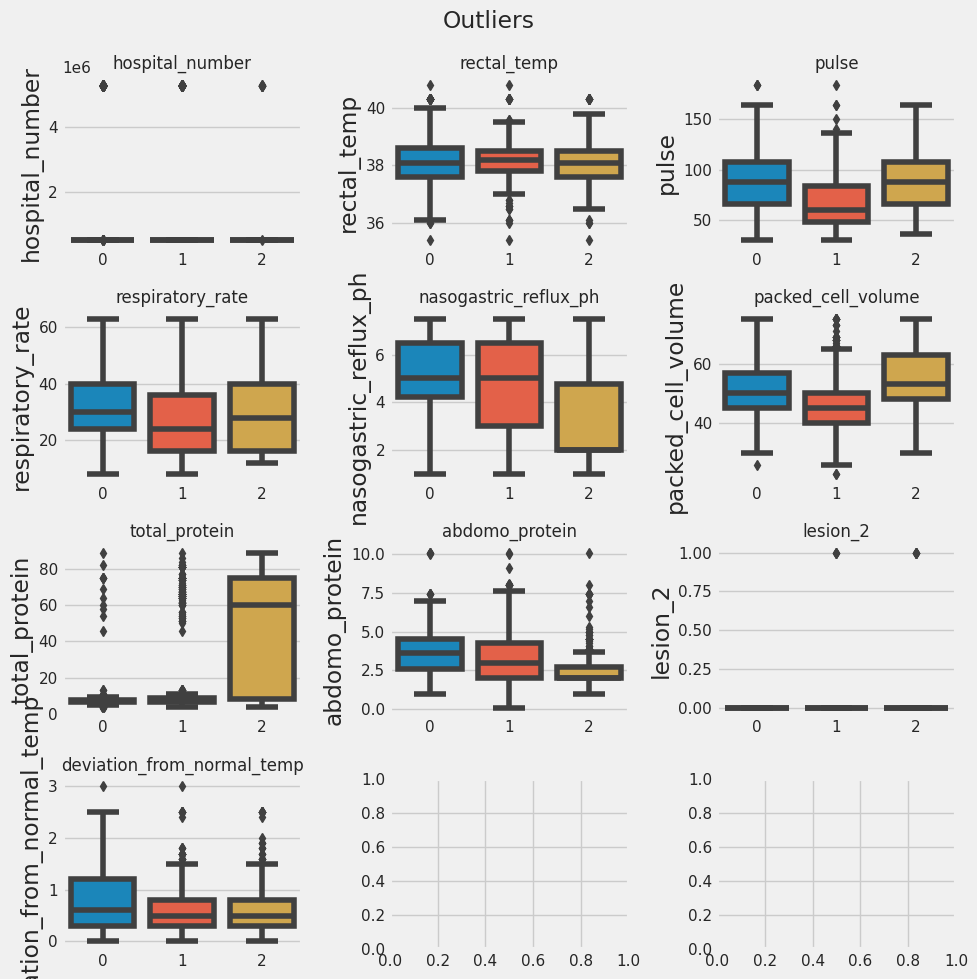

In [115]:
compute_outliers(train_df)

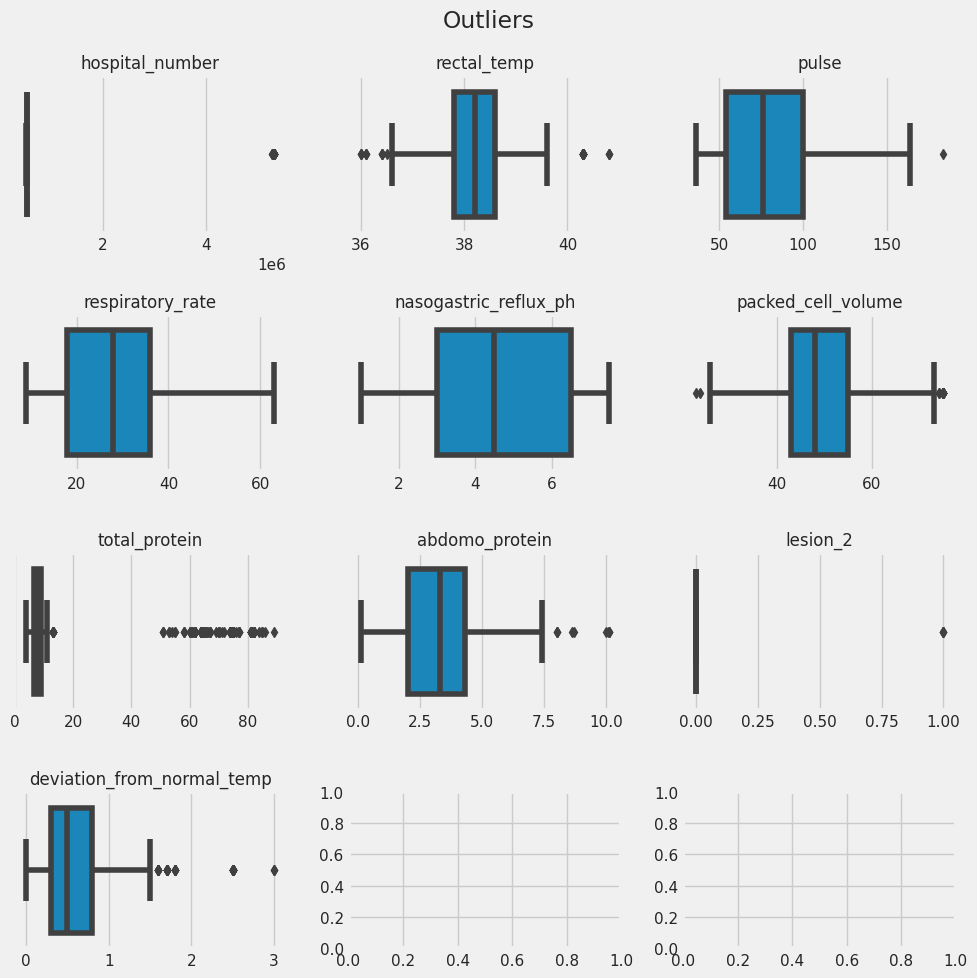

In [116]:
compute_outliers(test_df)

In [126]:
def train(model, cross_validator):
    df = train_df.copy()
    x = df.drop("outcome", axis=1)[categorical_features + numerical_features]
    y = df["outcome"]

    train_scores = []
    val_scores = []

    # pipeline = make_pipeline(
    #     ColumnTransformer([
    #         ("cat_cols",
    #          OneHotEncoder(sparse_output=False,
    #                        handle_unknown="ignore"), categorical_features),
    #         ("num_cols", MinMaxScaler(), numerical_features),
    #     ]), model)
    pipeline = model
    # pipeline = make_pipeline(
    #     ColumnTransformer([
    #         ("cat_cols", "passthrough", categorical_features),
    #         ("num_cols", StandardScaler(), numerical_features),
    #     ]),
    #     model
    # )

    print(f"Training Model: {model.__class__.__name__}")
    for train_idx, val_idx in cross_validator.split(x, y):
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(x_train, y_train)
        train_preds = pipeline.predict(x_train)
        val_preds = pipeline.predict(x_val)

        train_score = f1_score(y_train, train_preds, average="micro")
        val_score = f1_score(y_val, val_preds, average="micro")
        train_scores.append(train_score)
        val_scores.append(val_score)

    mean_train, std_train = np.mean(train_scores), np.std(train_scores)
    mean_val, std_val = np.mean(val_scores), np.std(val_scores)

    print(f"  Training scores: {round(mean_train, 5)} ± {round(std_train, 5)}")
    print(f"Validation scores: {round(mean_val, 5)} ± {round(std_val, 5)}")
    print()

    return train_scores, val_scores


def predict(model):
    df = train_df.copy()
    x_train = df.drop("outcome", axis=1)[categorical_features + numerical_features]
    y_train = df["outcome"]
    x_test = test_df.copy()[categorical_features + numerical_features]

    # pipeline = make_pipeline(
    #     ColumnTransformer([
    #         ("cat_cols",
    #          OneHotEncoder(sparse_output=False,
    #                        handle_unknown="ignore"), categorical_features),
    #         ("num_cols", MinMaxScaler(), numerical_features),
    #     ]), model)
    pipeline = model
    # pipeline = make_pipeline(
    #     ColumnTransformer([
    #         ("cat_cols", "passthrough", categorical_features),
    #         ("num_cols", StandardScaler(), numerical_features),
    #     ]),
    #     model
    # )

    print(f"Training Model: {model.__class__.__name__}")
    pipeline.fit(x_train, y_train)

    train_preds = pipeline.predict(x_train)
    train_score = f1_score(y_train, train_preds, average="micro")
    print(f"Training Score: {train_score}")

    test_preds = pipeline.predict(x_test)
    return test_preds

In [127]:
def train_voting_classifier(models, cross_validator):
    model = VotingClassifier(
        [(model.__class__.__name__, model) for model in models], voting="soft"
    )
    return train(model, cross_validator)


def predict_voting_classifier(models):
    model = VotingClassifier(
        [(model.__class__.__name__, model) for model in models], voting="soft"
    )
    return predict(model)

In [128]:
seed = 1337
np.random.seed(seed)

models = [
    AdaBoostClassifier(random_state=seed),
    CatBoostClassifier(random_state=seed, verbose=0),
    ExtraTreesClassifier(random_state=seed),
    # GaussianNB(),
    # GaussianProcessClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    HistGradientBoostingClassifier(random_state=seed),
    # KNeighborsClassifier(),
    # LinearDiscriminantAnalysis(),
    LGBMClassifier(random_state=seed),
    # MLPClassifier(hidden_layer_sizes=[256, 128],
    #               random_state=seed,
    #               learning_rate="adaptive"),
    RandomForestClassifier(random_state=seed),
    RidgeClassifier(random_state=seed),
    # SVC(random_state=seed, probability=True),
    XGBClassifier(random_state=seed),
]
skf_cv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

model_map = {model.__class__.__name__: model for model in models}

In [129]:
scores = pd.DataFrame()

for model in models:
    name = model.__class__.__name__
    _, scores[name] = train(model, skf_cv)

Training Model: AdaBoostClassifier
  Training scores: 0.73745 ± 0.00884
Validation scores: 0.68016 ± 0.02942

Training Model: CatBoostClassifier
  Training scores: 1.0 ± 0.0
Validation scores: 0.71498 ± 0.02668

Training Model: ExtraTreesClassifier
  Training scores: 1.0 ± 0.0
Validation scores: 0.7166 ± 0.02232

Training Model: GradientBoostingClassifier
  Training scores: 0.91032 ± 0.00451
Validation scores: 0.71822 ± 0.0296

Training Model: HistGradientBoostingClassifier
  Training scores: 1.0 ± 0.0
Validation scores: 0.71255 ± 0.03105

Training Model: LGBMClassifier
  Training scores: 1.0 ± 0.0
Validation scores: 0.71579 ± 0.02133

Training Model: RandomForestClassifier
  Training scores: 1.0 ± 0.0
Validation scores: 0.70607 ± 0.0241

Training Model: RidgeClassifier
  Training scores: 0.76012 ± 0.00356
Validation scores: 0.71012 ± 0.02369

Training Model: XGBClassifier
  Training scores: 1.0 ± 0.0
Validation scores: 0.71498 ± 0.02892



In [130]:
def plot_scores(scores):
    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=scores.reindex((-1 * scores).mean().sort_values().index, axis=1),
        orient="h",
    )
    plt.title("Scores", size=20)
    plt.grid(None)
    plt.show()

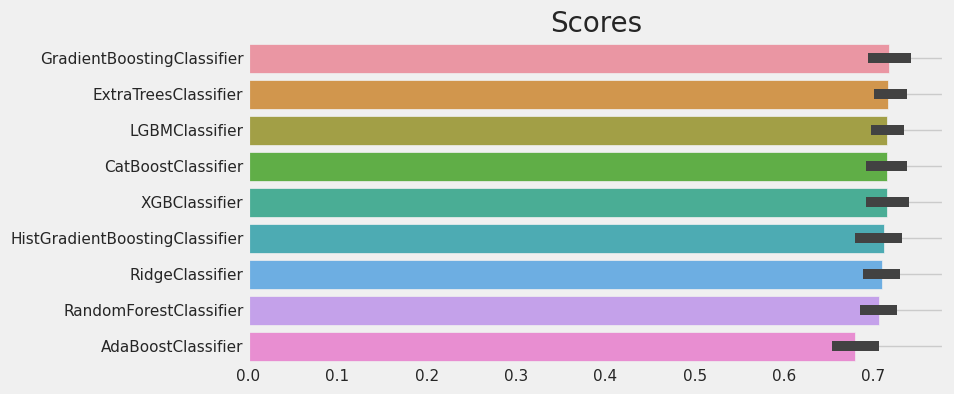

In [131]:
plot_scores(scores)

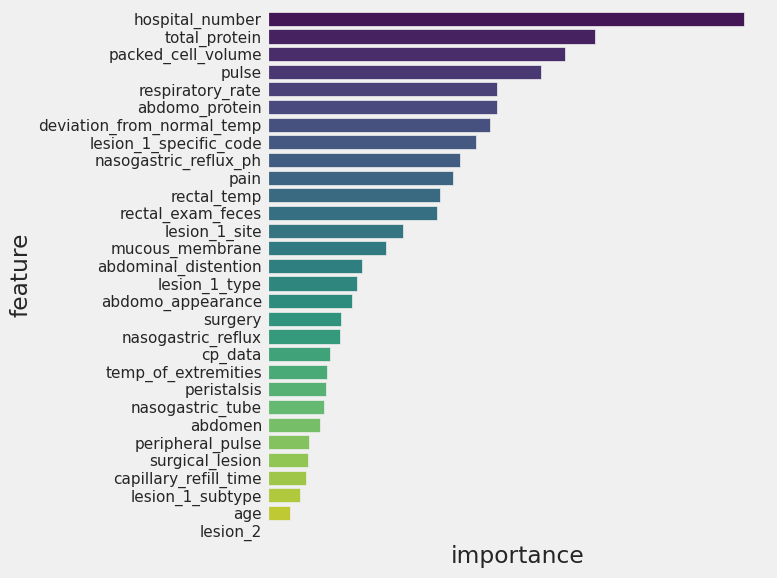

In [123]:
features = categorical_features + numerical_features
feature_importances = np.zeros((len(features)))

for model in models:
    if hasattr(model, "feature_importances_") and len(
        model.feature_importances_
    ) == len(features):
        feature_importances += model.feature_importances_

feature_df = pd.DataFrame({"feature": features, "importance": feature_importances})
feature_df.sort_values(by="importance", ascending=False, inplace=True)

plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=feature_df, x="importance", y="feature", palette="viridis")
plt.xticks([])
plt.grid(False)
plt.tight_layout()
plt.show()

In [132]:
top_k = 3
models = scores.reindex((-1 * scores).mean().sort_values().index, axis=1).columns[
    :top_k
]
best_models = [model_map[name] for name in models]

In [134]:
_ = train_voting_classifier(best_models, skf_cv)

Training Model: VotingClassifier
  Training scores: 1.0 ± 0.0
Validation scores: 0.72389 ± 0.03045



([1.0, 1.0, 1.0, 1.0, 1.0],
 [0.680161943319838,
  0.7449392712550607,
  0.7004048582995951,
  0.728744939271255,
  0.7651821862348178])

In [133]:
submission_df = pd.read_csv("sample_submission.csv", index_col="id")
submission_df["outcome"] = predict_voting_classifier(best_models)
submission_df["outcome"] = submission_df["outcome"].apply(
    lambda x: "died" if x == 0 else "lived" if x == 1 else "euthanized"
)
submission_df.to_csv(f"VotingClassifier_submission-v8.csv")

Training Model: VotingClassifier
Training Score: 1.0
